In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Encoder/Freq'

/content/drive/My Drive/Siamese/Encoder/Freq


In [3]:
import sys
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

In [4]:
!pip install torchaudio

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 20

torch.backends.cudnn.deterministic = True
B = 32

WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
NUM_WORKERS = 4

NUM_CLASSES = 200

In [7]:
from Normalize import Normalize
from ToTensor import ToTensor
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

trainset = IdentificationDataset(DATASET_PATH, 
                                 NUM_CLASSES,
                                 train=True, 
                                 transform=transforms,
                                 lenght=2,
                                 return_type=ReturnType.ENCODER)
trainsetloader = torch.utils.data.DataLoader(trainset, 
                                             batch_size=B, 
                                             num_workers=NUM_WORKERS, 
                                             shuffle=True)

testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=2,
                                return_type=ReturnType.ENCODER)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=4, 
                                            num_workers=NUM_WORKERS)

print("lenght train loader ", len(trainsetloader))
print("lenght test loader ", len(testsetloader))


sample lenght  2
sample lenght  2
lenght train loader  742
lenght test loader  534


In [8]:
from TransFourier import TransFourier

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = TransFourier(pairwise=False)
net.to(DEVICE)

cuda


TransFourier(
  (spectrogram): Spectrogram()
  (amp): AmplitudeToDB()
  (block1): Conv2DBlock(
    (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Conv2DBlock(
    (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Conv2DBlock(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(256, 192, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1

In [9]:
import numpy as np
optimizer = optim.SGD(net.parameters(), LR_INIT, MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

max_accuracy = 0
test_accuracy = []
train_accuracy = []

train_loss = 0
train_losses = []
test_loss = 0
test_losses = []

for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    lr_scheduler.step()
    
    # train
    print("*** Train ***")
    net.train()

    accuracy = 0
    nb_test = 0
    
    for iter_num, (_, a, p, n_label, n) in tqdm(enumerate(trainsetloader)):
        optimizer.zero_grad()
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)

        loss, results, a, p, n = net(a, p , n)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1

    train_accuracy.append(accuracy/nb_test)
    train_loss /= len(trainsetloader)
    train_losses.append(train_loss)

    # test
    net.eval()
    print("*** Test ***")
    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (label, a, p, n_label, n) in tqdm(enumerate(testsetloader)):
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        loss, results, a, p, n = net(a, p , n)

        # Calculate loss
        test_loss += loss.item()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1
    
    accuracy /= nb_test
    test_accuracy.append(accuracy)
    print("accuracy = ", accuracy)
    if accuracy > max_accuracy:
      net.store_encoder(2)
      max_accuracy = accuracy
    test_loss /= len(testsetloader)
    test_losses.append(test_loss)


*** Epoch  0  ***
*** Train ***


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
742it [05:46,  2.14it/s]

*** Test ***



534it [00:13, 40.54it/s]


accuracy =  0.7614807872539832
*** Epoch  1  ***
*** Train ***


742it [05:46,  2.14it/s]

*** Test ***



534it [00:13, 41.06it/s]

accuracy =  0.7666354264292409
*** Epoch  2  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.27it/s]

accuracy =  0.7652296157450796
*** Epoch  3  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:13, 40.91it/s]

accuracy =  0.7699156513589503
*** Epoch  4  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.67it/s]

accuracy =  0.7755388940955952
*** Epoch  5  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.27it/s]

accuracy =  0.7764761012183693
*** Epoch  6  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.10it/s]

accuracy =  0.7591377694470478
*** Epoch  7  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.37it/s]

accuracy =  0.7685098406747891
*** Epoch  8  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:13, 41.02it/s]

accuracy =  0.7713214620431116
*** Epoch  9  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:13, 40.68it/s]

accuracy =  0.7699156513589503
*** Epoch  10  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:13, 41.00it/s]

accuracy =  0.7731958762886598
*** Epoch  11  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:13, 40.94it/s]

accuracy =  0.7727272727272727
*** Epoch  12  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:13, 40.47it/s]

accuracy =  0.7703842549203374
*** Epoch  13  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:13, 41.00it/s]

accuracy =  0.7755388940955952
*** Epoch  14  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:12, 41.11it/s]

accuracy =  0.7755388940955952
*** Epoch  15  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:12, 41.09it/s]

accuracy =  0.7666354264292409
*** Epoch  16  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.26it/s]

accuracy =  0.7760074976569822
*** Epoch  17  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.14it/s]

accuracy =  0.7699156513589503
*** Epoch  18  ***
*** Train ***



742it [05:46,  2.14it/s]

*** Test ***



534it [00:12, 41.39it/s]

accuracy =  0.7783505154639175
*** Epoch  19  ***
*** Train ***



742it [05:47,  2.14it/s]

*** Test ***



534it [00:12, 41.09it/s]

accuracy =  0.7717900656044986


train accuracy end:0.842 max:0.846
test accuracy end:0.772 max:0.778


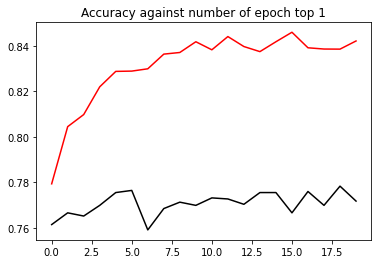

In [10]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], train_accuracy , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_accuracy , label='test 1', color='black')
print('train accuracy end:{} max:{}'
.format(round(train_accuracy[EPOCH_NUM-1], 3), round(np.max(train_accuracy), 3)))
print('test accuracy end:{} max:{}'
.format(round(test_accuracy[EPOCH_NUM-1], 3), round(np.max(test_accuracy), 3)))


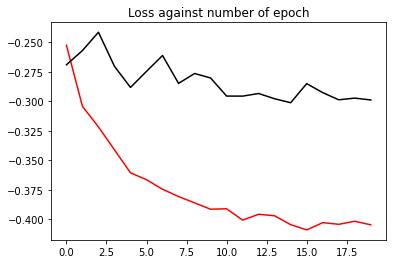

In [11]:
plt.title("Loss against number of epoch")
plt.plot([i for i in range(EPOCH_NUM)], train_losses , label='Train loss', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_losses , label='Test loss', color='black')
